In [1]:
from typing import List,TypedDict

from langchain_community.document_loaders import PyPDFLoader,PyPDFDirectoryLoader
from langchain_community.vectorstores import FAISS
from langchain_text_splitters import  RecursiveCharacterTextSplitter
from langchain_openai import ChatOpenAI
from langchain_core.documents import Document
from langchain_core.prompts import ChatPromptTemplate
from langchain_huggingface import HuggingFaceEmbeddings
from pydantic import BaseModel
from langchain_community.tools import TavilySearchResults

from langgraph.graph import START,StateGraph,END
from dotenv import load_dotenv
import os
import re


d:\Vaibhav_PC\GenerativeAI\GI\Advance_RAG\Campus_RAG\CRAG\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:

load_dotenv()

OPENROUTER_API_KEY=os.getenv("OPENROUTER_API_KEY")
tavily_api_key=os.getenv("TAVILY_API_KEY")

os.environ["OPENROUTER_API_KEY"]=OPENROUTER_API_KEY
os.environ["TAVILY_API_KEY"]=tavily_api_key

model= ChatOpenAI( base_url="https://openrouter.ai/api/v1",
    api_key=OPENROUTER_API_KEY,
    model= "upstage/solar-pro-3:free"
)
model.invoke("hello")

AIMessage(content="Hello! 👋 I'm Solar\u202fPro\u202f3, a large language model developed by Upstage. How can I help you today?", additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 214, 'prompt_tokens': 66, 'total_tokens': 280, 'completion_tokens_details': {'accepted_prediction_tokens': None, 'audio_tokens': 0, 'reasoning_tokens': 180, 'rejected_prediction_tokens': None}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 64}, 'cost': 0, 'is_byok': False, 'cost_details': {'upstream_inference_cost': 0, 'upstream_inference_prompt_cost': 0, 'upstream_inference_completions_cost': 0}}, 'model_provider': 'openai', 'model_name': 'upstage/solar-pro-3:free', 'system_fingerprint': None, 'id': 'gen-1771070390-IQRSSl9vTvOq7zfNNbAi', 'finish_reason': 'stop', 'logprobs': None}, id='lc_run--019c5c05-7fa0-7813-8486-d38607b3b442-0', tool_calls=[], invalid_tool_calls=[], usage_metadata={'input_tokens': 66, 'output_tokens': 214, 'total_tokens': 280, 'inp

In [3]:
docs = (
    PyPDFLoader("./documents/book1.pdf").load()
    + PyPDFLoader("./documents/book2.pdf").load()
    + PyPDFLoader("./documents/book3.pdf").load()
)

In [4]:
chunks = RecursiveCharacterTextSplitter(chunk_size=900, chunk_overlap=150).split_documents(docs)
for d in chunks:
    d.page_content = d.page_content.encode("utf-8", "ignore").decode("utf-8", "ignore")

In [5]:
embeddings = HuggingFaceEmbeddings(
    model_name="sentence-transformers/all-MiniLM-L6-v2",
)


In [6]:
vector_store = FAISS.from_documents(chunks, embeddings)
retriever = vector_store.as_retriever(search_type="similarity", search_kwargs={"k": 4})

In [7]:
UPPER_TH = 0.7
LOWER_TH = 0.3

In [8]:
class State(TypedDict):

    question: str
    docs: List[Document]

    good_docs: List[Document]
    verdict: str
    reason: str

    strips: List[str]
    kept_strips: List[str]
    refined_context: str

    web_docs: List[Document]  
    web_query: str

    
    answer: str

In [9]:

def retrieve(state: State) -> State:
    q = state["question"]
    return {"docs": retriever.invoke(q)}

In [10]:
# -----------------------------
# Score-based doc evaluator
# -----------------------------
class DocEvalScore(BaseModel):
    score: float
    reason: str

doc_eval_prompt = ChatPromptTemplate.from_messages(
    [
        (
            "system",
            "You are a strict retrieval evaluator for RAG.\n"
            "You will be given ONE retrieved chunk and a question.\n"
            "Return a relevance score in [0.0, 1.0].\n"
            "- 1.0: chunk alone is sufficient to answer fully/mostly\n"
            "- 0.0: chunk is irrelevant\n"
            "Be conservative with high scores.\n"
            "Also return a short reason.\n"
            "Output JSON only.",
        ),
        ("human", "Question: {question}\n\nChunk:\n{chunk}"),
    ]
)

doc_eval_chain = doc_eval_prompt | model.with_structured_output(DocEvalScore)

def eval_each_doc_node(state: State) -> State:

    q = state["question"]
    
    scores: List[float] = []
    reasons: List[str] = []
    good: List[Document] = []

    for d in state["docs"]:
        out = doc_eval_chain.invoke({"question": q, "chunk": d.page_content})
        scores.append(out.score)
        reasons.append(out.reason)

        # 5) for CORRECT case we will refine only docs with score > LOWER_TH
        if out.score > LOWER_TH:
            good.append(d)

    # 2) CORRECT if at least one doc > UPPER_TH
    if any(s > UPPER_TH for s in scores):
        return {
            "good_docs": good,
            "verdict": "CORRECT",
            "reason": f"At least one retrieved chunk scored > {UPPER_TH}.",
        }

    # 3) INCORRECT if all docs < LOWER_TH
    if len(scores) > 0 and all(s < LOWER_TH for s in scores):
        why = "No chunk was sufficient."
        return {
            "good_docs": [],
            "verdict": "INCORRECT",
            "reason": f"All retrieved chunks scored < {LOWER_TH}. {why}",
        }

    # 4) Anything in between => AMBIGUOUS
    why = "Mixed relevance signals."
    return {
        "good_docs": good,
        "verdict": "AMBIGUOUS",
        "reason": f"No chunk scored > {UPPER_TH}, but not all were < {LOWER_TH}. {why}",
    }

In [18]:
# -----------------------------
# Sentence-level DECOMPOSER
# -----------------------------
def decompose_to_sentences(text: str) -> List[str]:
    text = re.sub(r"\s+", " ", text).strip()
    sentences = re.split(r"(?<=[.!?])\s+", text)
    return [s.strip() for s in sentences if len(s.strip()) > 20]

# -----------------------------
# FILTER (LLM judge)
# -----------------------------
class KeepOrDrop(BaseModel):
    keep: bool

filter_prompt = ChatPromptTemplate.from_messages(
    [
        (
            "system",
            "You are a strict relevance filter.\n"
            "Return keep=true only if the sentence directly helps answer the question.\n"
            "Use ONLY the sentence. Output JSON only.",
        ),
        ("human", "Question: {question}\n\nSentence:\n{sentence}"),
    ]
)

filter_chain = filter_prompt | model.with_structured_output(KeepOrDrop)

# -----------------------------
# REFINING (Decompose -> Filter -> Recompose)
# -----------------------------
def refine(state: State) -> State:
    q = state["question"]

    if state.get("verdict") == "CORRECT":
        doc_to_use = state['good_docs']
    elif state.get("verdict") == "INCORRECT" :
        doc_to_use = state['web_docs']
    else:
        doc_to_use = state["good_docs"]+state["web_docs"]
    
        
        
    context = "\n\n".join(d.page_content for d in  doc_to_use).strip()
    strips = decompose_to_sentences(context)
 
    kept: List[str] = []
    for s in strips:
        if filter_chain.invoke({"question": q, "sentence": s}).keep:
            kept.append(s)

    refined_context = "\n".join(kept).strip()

    return {
        "strips": strips,
        "kept_strips": kept,
        "refined_context": refined_context,
    }

In [20]:
class WebQuerry(BaseModel):
    query:str
    
rewrite_prompt = ChatPromptTemplate.from_messages(
    [
        (
            "system",
            "Rewrite the user question into a web search query composed of keywords.\n"
            "Rules:\n"
            "- Keep it short (6–14 words).\n"
            "- If the question implies recency (e.g., recent/latest/last week/last month), add a constraint like (last 30 days).\n"
            "- Do NOT answer the question.\n"
            "- Return JSON with a single key: query",
        ),
        ("human", "Question: {question}"),
    ]
)

rewrite_chain = rewrite_prompt | model.with_structured_output(WebQuerry)

def rewrite_query(state:State) -> State:
    out = rewrite_chain.invoke({'question':state['question']})
    return {'web_query': out.query}

tavily = TavilySearchResults(max_results=5,
                            TAVILY_API_KEY=tavily_api_key)

def web_search_node(state: State) -> State:

    q = state.get('web_query') or state['question']  # fallback if query empty
    results = tavily.invoke({"query": q})  # no knowledge selection


    web_docs = []
    for r in results or []:

        title = r.get("title", "")
        url = r.get("url", "")
        content = r.get("content", "") or r.get("snippet", "")
        
        text = f"TITLE: {title}\nURL: {url}\nCONTENT:\n{content}"

        web_docs.append(Document(page_content=text, metadata={"url": url, "title": title}))

    return {"web_docs": web_docs}

In [21]:
answer_prompt = ChatPromptTemplate.from_messages(
    [
        (
            "system",
            "You are a helpful ML tutor. Answer ONLY using the provided context.\n"
            "If the context is empty or insufficient, say: 'I don't know.'",
        ),
        ("human", "Question: {question}\n\nRefined context:\n{refined_context}"),
    ]
)

def generate(state: State) -> State:
    out = (answer_prompt | model).invoke(
        {"question": state["question"], "refined_context": state["refined_context"]}
    )
    return {"answer": out.content}

In [22]:

# -----------------------------
# Routing
# CORRECT => refine
# INCORRECT / AMBIGUOUS => rewrite -> web_search -> refine -> generate
# -----------------------------
def route_after_eval(state: State) -> str:
    if state["verdict"] == "CORRECT":
        return "refine"
    else:
        return "rewrite_query"

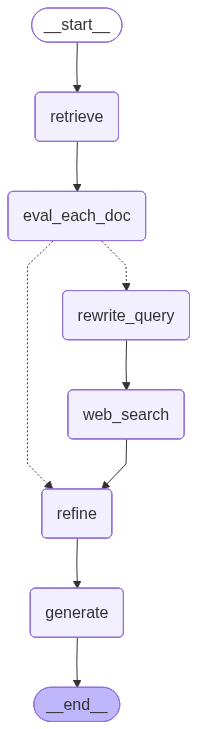

In [23]:
# -----------------------------
# Graph
# -----------------------------
g = StateGraph(State)

g.add_node("retrieve", retrieve)
g.add_node("eval_each_doc", eval_each_doc_node)

g.add_node('rewrite_query', rewrite_query)
g.add_node("web_search", web_search_node)

g.add_node("refine", refine)          # uses verdict to pick good_docs vs web_docs
g.add_node("generate", generate)


# flow
g.add_edge(START, "retrieve")
g.add_edge("retrieve", "eval_each_doc")

# route after evaluation
g.add_conditional_edges(
    "eval_each_doc",
    route_after_eval,
    {
        "refine": "refine",          # CORRECT -> refine (good_docs)
        "rewrite_query": "rewrite_query",  # INCORRECT -> web_search
        
    },
)

# Incorrect path : rewrite_query -> web_search -> refine -> generate
g.add_edge('rewrite_query','web_search')
g.add_edge("web_search", "refine")   
g.add_edge("refine", "generate")      

g.add_edge("generate", END)


app = g.compile()
app

In [24]:
# -----------------------------
# Run example
# -----------------------------
res = app.invoke(
    {
        "question": "Batch normalization vs layer normalization",
        "docs": [],
        "good_docs": [],
        "verdict": "",
        "reason": "",
        "strips": [],
        "kept_strips": [],
        "refined_context": "",
        "web_query": "",
        "web_docs": [],
        "answer": "",
    }
)

print("VERDICT:", res["verdict"])
print("REASON:", res["reason"])
print("WEB_QUERY:", res["web_query"])
print("\nOUTPUT:\n", res["answer"])

VERDICT: AMBIGUOUS
REASON: No chunk scored > 0.7, but not all were < 0.3. Mixed relevance signals.
WEB_QUERY: batch normalization vs layer normalization differences

OUTPUT:
 **Batch Normalization vs. Layer Normalization – Key Points**

| Aspect | **Batch Normalization (BN)** | **Layer Normalization (LN)** |
|--------|------------------------------|------------------------------|
| **Normalization axis** | Across the **mini‑batch dimension** (mean & std. computed per feature from all samples in the batch). | Across the **features of each individual sample** (mean & std. computed from the feature vector of a single sample). |
| **Typical use cases** | Feed‑forward deep nets and convolutional networks (CNNs) where a sizeable, homogeneous batch is easy to collect. | Recurrent neural networks (RNNs), Transformer‑style models, and any architecture where sequence length varies or the batch size is small / variable. |
| **Dependency on batch size** | Performance **degrades** when the batch is